# Which Debts Are Worth the Bank's Effort?
Play bank data scientist and use regression discontinuity to see which debts are worth collecting.

# Project Description
After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.
Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.



## problem Statement:

<p><strong>The big question</strong>: Does the extra amount that is recovered at the higher strategy level exceed the extra \$50 in costs? In other words, was there a jump (also called a "discontinuity") of more than \$50 in the amount recovered at the higher strategy level? We'll find out in this notebook.</p>

## 1. Regression discontinuity: banking recovery
The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future. This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.</p>
<p>The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to obtain payments. Each additional level of recovery strategy requires an additional \$50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0. Customers in Level 2 cost \$50 more than those in Level 1, etc. </p>





## EDA(Exploratory Data Analysis)

In [1]:
#Importing libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read the dataset
df= pd.read_csv("bank_data.csv")

# print first five rows
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [3]:
# size of the dataset
df.shape

(1882, 6)

* There are 1882 rows and 6 columns in the dataset

In [4]:
# Brief information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [17]:
#To see null values 
df.isnull().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [18]:
# To see duplicate values
df.duplicated().sum()

0

In [5]:
# Statistical discription of the numerical columns
df.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


* This is description of only numerical data but we have categorical column also like 'recovery_strategy' which is important for our further analysis.
For analysis purpose we convert this into numeric format


In [8]:
df['recovery_strategy'].unique()

array(['Level 0 Recovery', 'Level 1 Recovery', 'Level 2 Recovery',
       'Level 3 Recovery', 'Level 4 Recovery'], dtype=object)

In [9]:
df_copy= df.copy()
df_copy.head(2)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.54,Level 0 Recovery,19,Male
1,1150,486,416.09,Level 0 Recovery,25,Female


In [19]:
df_copy['recovery_strategy']= df_copy['recovery_strategy'].replace(['Level 0 Recovery','Level 1 Recovery','Level 2 Recovery','Level 3 Recovery','Level 4 Recovery'],[0,1,2,3,4])
df_copy.describe()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age
count,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,1.857598,39.650372
std,591.458429,2019.826565,4576.506350,1.272085,15.453072
min,6.000000,194.000000,200.425000,0.000000,18.000000
25%,534.250000,1261.250000,1045.190300,1.000000,28.000000
50%,1029.500000,2062.000000,2115.446373,2.000000,35.000000
75%,1551.750000,3569.500000,5417.237207,3.000000,50.000000
max,2056.000000,9964.000000,34398.479710,4.000000,84.000000


## Visualization

<Figure size 360x360 with 0 Axes>

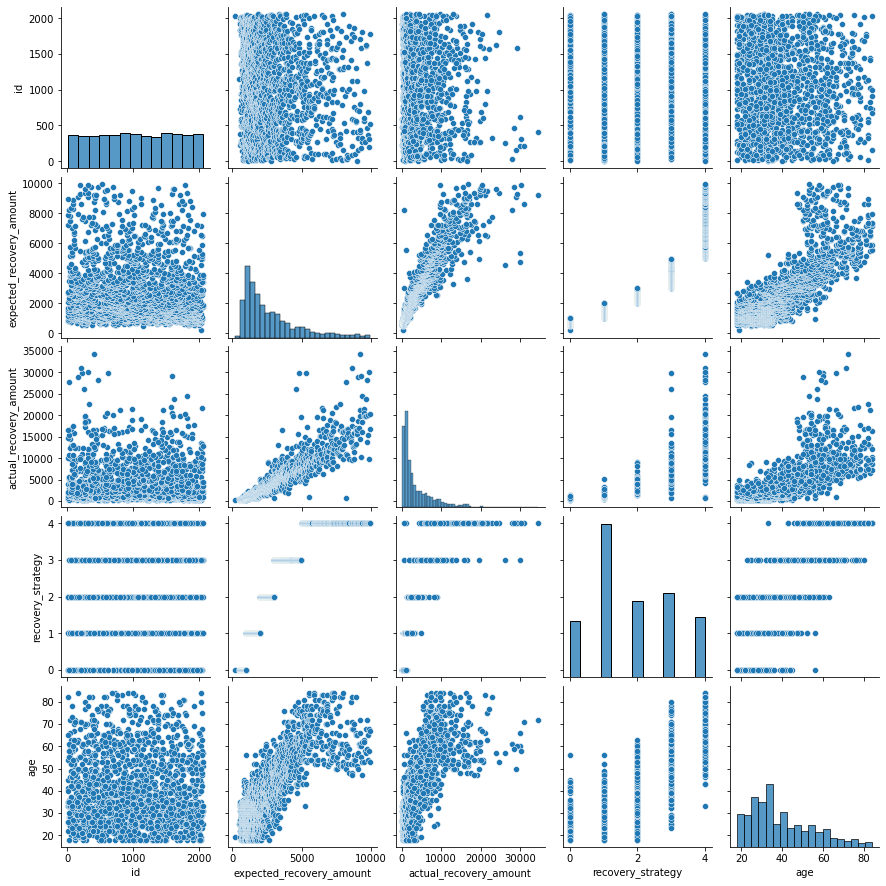

In [11]:
#To see pairwise relationships between variables within a dataset
plt.figure(figsize=(5,5))
sns.pairplot(df_copy)
plt.show()

* From the pairplot we can see that there is linear relation between expected_recovery_amount and actual_recovery_amount

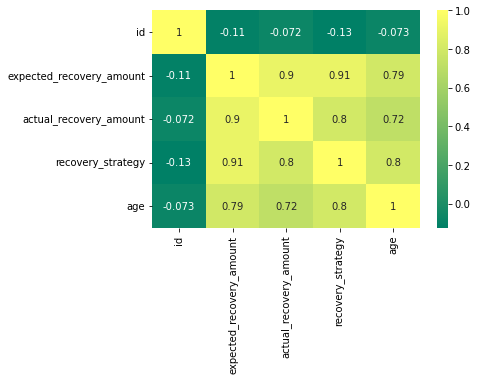

In [12]:
# To see which variables are related to each other and the strength of this relationship
sns.heatmap(df_copy.corr(), annot= True, cmap='summer')
plt.show()

* From this heatmap expected_recovery_amount is good correlated with actual_recovery_amount ,recovery_strategy, age and vice versa. Actual_recovery_amount is nicely correlated with age, recovery_strategy and vice versa.

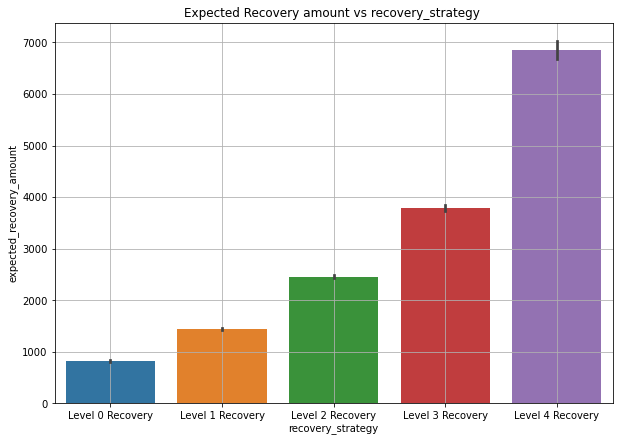

In [13]:
# Expected Recovery amount vs recovery_strategy
plt.figure(figsize=(10,7))
sns.barplot(data=df, x='recovery_strategy', y='expected_recovery_amount')

plt.title("Expected Recovery amount vs recovery_strategy ")
plt.xlabel("recovery_strategy")
plt.ylabel("expected_recovery_amount")
plt.grid()
plt.show()

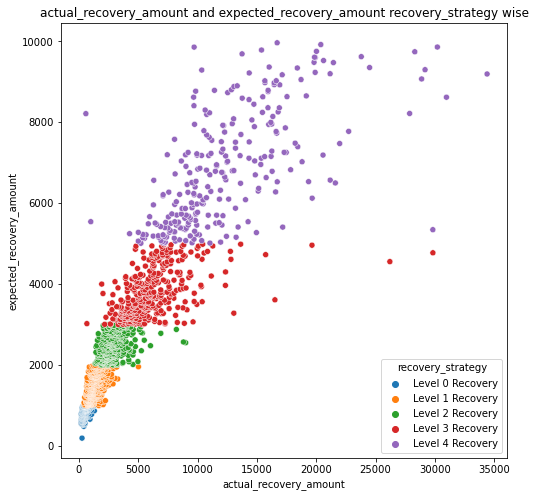

In [21]:
#actual_recovery_amount and expected_recovery_amount recovery_strategy wise")
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='actual_recovery_amount', y='expected_recovery_amount', hue= 'recovery_strategy')
plt.title("actual_recovery_amount and expected_recovery_amount recovery_strategy wise")
plt.show()

## 2. Graphical exploratory data analysis

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, $3000 and $5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between $0 and $2000 where the transition between Levels occurred at $1000. We know that the customers in Level 1 (expected recovery amounts between $1001 and $2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between $1 and $1000).

Here's a quick summary of the Levels and thresholds again:
Level 0: Expected recovery amounts >$0 and <=$1000
Level 1: Expected recovery amounts >$1000 and <=$2000
The threshold of $1000 separates Level 0 from Level 1

A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the $1000 threshold. For example, does the customer age show a jump (discontinuity) at the $1000 threshold or does that age vary smoothly? 

* We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, $0 to $2000. This range covers Levels 0 and 1.

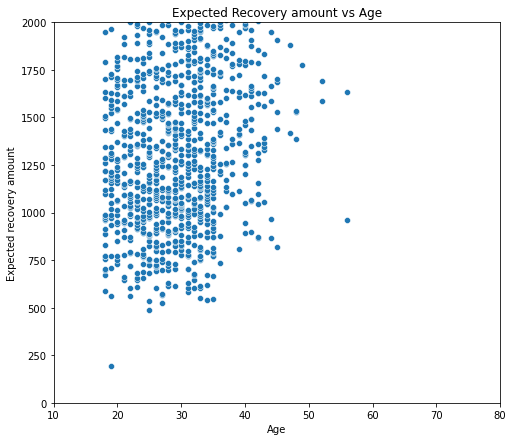

In [15]:
plt.figure(figsize=(8,7))
sns.scatterplot(data=df,x='age', y='expected_recovery_amount')
plt.xlim(10,80)
plt.ylim(0,2000)
plt.title("Expected Recovery amount vs Age")
plt.xlabel("Age")
plt.ylabel("Expected recovery amount")
plt.show()

# Explanation:
* The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000

## 3. Statistical test: age vs. expected recovery amount
We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.
The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from $900 to $1100.

* Here we use one-way ANOVA test using the 'pingouin' package 

In [22]:
#!pip install pingouin
import pingouin as pg
from pingouin import pairwise_ttests

ex_re_am_900_1100= df[(df['expected_recovery_amount']>=900) & (df['expected_recovery_amount']<1100)]

pg.pairwise_gameshowell(data=ex_re_am_900_1100, dv='age', between='recovery_strategy')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Level 0 Recovery,Level 1 Recovery,27.224719,28.755319,-1.5306,0.90851,-1.684736,177.395495,0.093798,-0.248737


# Explanation:
* As pvalue > level of significance(0.05) so there is no any difference in the ages just above and below the threshold.

## 4.Statistical test: sex vs. expected recovery amount
We were able to convince ourselves that there is no major jump in the average customer age just above and just below the $1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.
We want to also test that the percentage of customers that are male does not jump as well across the $1000 threshold. We can start by exploring the range of $900 to $1100 and later adjust this range.

* As our sample data is in categorical format, to examine this we use chi-square tests.

In [24]:
from scipy import stats

table= pd.crosstab(ex_re_am_900_1100['recovery_strategy'],df['sex'])
print(table)
print()
statistic, pvalue, dof, expect= stats.chi2_contingency(table)
print("chi-square statistic:", statistic)
print("p_value:", pvalue)
print("Degree of freedom:", dof)
print("expected observations:", expect)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55

chi-square statistic: 0.3796422112341753
p_value: 0.5377947810444592
Degree of freedom: 1
expected observations: [[34.53005464 54.46994536]
 [36.46994536 57.53005464]]


# Explanation:
* As pvalue > level of significance(0.05) , i.e there is no any significant association between the two variables.So features like 'sex' and 'recovery strategy' are independent.

## 5. Exploratory graphical analysis: recovery amount
We are now reasonably confident that customers just above and just below the $1000 threshold are, on average, similar in terms of their average age and the percentage that are male.
It is now time to focus on the key outcome of interest, the actual recovery amount.
A first step in examining the relationship between the actual recovery amount and the expected recovery amount. 

* Develop a scatter plot where we want to focus our attention at the range just below and just above the threshold.Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between $900 to $1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the $1000 threshold.

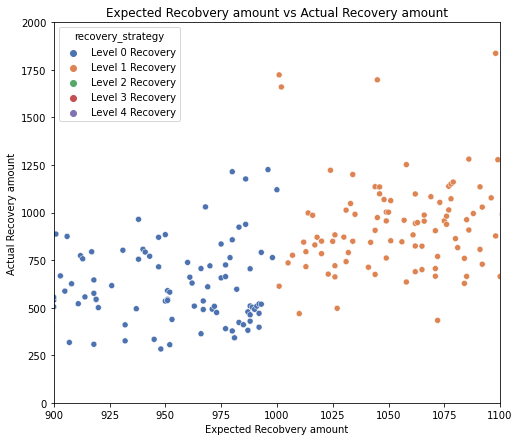

In [25]:
plt.figure(figsize=(8,7))
sns.scatterplot(data= df, x='expected_recovery_amount', y='actual_recovery_amount', hue='recovery_strategy', palette="deep")
plt.xlim(900,1100)
plt.ylim(0,2000)
plt.xlabel('Expected Recobvery amount')
plt.ylabel('Actual Recovery amount')
plt.title('Expected Recobvery amount vs Actual Recovery amount')
plt.show()



# Explanation:
* It seems there is a no discontinuity. We can say that average actual recovery amount for level 0 to be less than the average actual recovery amount for level 1.

## 6. Statistical analysis: recovery amount
Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount $900 to $1100 and for a narrow range of $950 to $1050 to see if our results are consistent.
 
* we will use the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount



In [26]:
ex_950_1050 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]
actual_level0=  ex_950_1050[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
actual_level1= ex_950_1050[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']

stats.kruskal(actual_level0,actual_level1)


KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)

# Explanation:
* For the range of $900  to $1100, the resulting p-value is almost zero which suggests that the medians for the actual recovery amounts just above the threshold and just below the threshold are different.

- Now check for the range 950 to 1050

In [27]:
ex_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
actual_level0=  ex_950_1050[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
actual_level1= ex_950_1050[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']

stats.kruskal(actual_level0,actual_level1)


KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

# Explanation:
* For the range of $950 to $1050, the resulting p-value is also close to zero which implies that the medians for the actual recovery amounts just above the threshold and just below the threshold are different.

## 7.Regression modeling: no threshold
We now want to take a regression-based approach to estimate the impact of the program at the $1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.
The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [30]:
x= ex_re_am_900_1100[['expected_recovery_amount']].values
y= ex_re_am_900_1100['actual_recovery_amount']

In [31]:
logreg= LinearRegression()
logreg.fit(x,y)
pred=logreg.predict(x)

print("Score:",r2_score(y, pred))
print()
print("coefficient:",logreg.coef_)
print("intercept:", logreg.intercept_)

Score: 0.26055416614656146

coefficient: [2.75765842]
intercept: -1978.7597394261234


# Explanation:
* Coefficient of expected_recovery_amount is significant for the model.

## 8.Regression modeling: adding true threshold
From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.
The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [32]:
df["indicator"]= np.where(df["expected_recovery_amount"]<1000, 0, 1)

ex_re_am_900_1100= df[(df["expected_recovery_amount"]<1100) & (df["expected_recovery_amount"]>=900)]

x_thresh= ex_re_am_900_1100[['expected_recovery_amount','indicator']].values
y_thresh= ex_re_am_900_1100['actual_recovery_amount']

logreg1= LinearRegression()
logreg1.fit(x_thresh,y_thresh)
pred1= logreg1.predict(x_thresh)

print("score:",r2_score(y_thresh, pred1))
print()


coefficeint=pd.DataFrame(logreg1.coef_, index=['expected_recovery_amount','indicator'], columns=['Coefficients'])
print(coefficeint)

print("intercepts:", logreg1.intercept_)

score: 0.3141270744516168

                          Coefficients
expected_recovery_amount      0.642983
indicator                   277.634419
intercepts: 3.344024967607197


# Explanation
* The additional amount recovered from the higher recovery strategy is due to regression coefficient of true threshold. It tells the size of the discontinuity for customers just above and just below the threshold. 
* If regression coefficient of the true threshold > zero then higher recovery strategy will help to recover more money.
* Here we get the coefficient value for true threshold is grester than zero.

## 9.Regression modeling: adjusting the window
The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278. This is much larger than the incremental cost of running the higher recovery strategy which was $50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.
Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of $900 to $1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from $950 to $1050 to see if we get similar results

In [33]:
ex_re_am_950_1050= df[(df["expected_recovery_amount"]<1050) & (df["expected_recovery_amount"]>=950)]

x_new_window = ex_re_am_950_1050[['expected_recovery_amount','indicator']].values
y_new_window = ex_re_am_950_1050['actual_recovery_amount']

logreg2= LinearRegression()
logreg2.fit(x_new_window,y_new_window)
pred2= logreg2.predict(x_new_window)

print(r2_score(y_new_window, pred2))
print()

coefficeint=pd.DataFrame(logreg2.coef_, index=['expected_recovery_amount','indicator'], columns=['Coefficients'])
print(coefficeint)
print("intercepts:", logreg2.intercept_)


0.2834733924219919

                          Coefficients
expected_recovery_amount      0.918933
indicator                   286.533653
intercepts: -279.52430066671775


# Explanation:
* Again For small window we get significant value for true threshold, so here also higher recovery strategy will help to recover more money

## conclusion:
* We can say that extra amount that is recovered at the higher strategy level exceed the extra $50 in costs. That means there is a jump (also called a "discontinuity") of more than $50 in the amount recovered at the higher strategy level.